<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step4b_predict_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepPoseKit Step 4b - Predict on new data

This is step 4b of the example notebooks for using DeepPoseKit. This notebook shows you how to use your trained model to make predictions on a novel video, detect outliers, merge the outliers with the existing annotation set, and visualize the data output.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

**If you're using Colab**: make sure to go to the “Runtime” dropdown menu, select “Change runtime type” and select `GPU` in the "Hardware accelerator" drop-down menu


If you haven't already installed DeepPoseKit you can run the next cell

In [ ]:
import sys
!{sys.executable} -m pip install -U deepposekit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit.io import DataGenerator, VideoReader, VideoWriter
from deepposekit.io.utils import merge_new_images

import tqdm
import time

from scipy.signal import find_peaks

from os.path import expanduser
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

/home/jake/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

Use the next cell to download the example data into your home directory

In [2]:
!git clone https://github.com/jgraving/deepposekit-data {HOME + '/deepposekit-data'}

fatal: destination path '/home/jake/deepposekit-data' already exists and is not an empty directory.


Find the saved models

In [2]:
models = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*model*.h5'))
models

['/home/jake/deepposekit-data/datasets/fly/best_model_densenet.h5',
 '/home/jake/deepposekit-data/datasets/fly/best_model_fly_densenet.h5']

# Load the trained model

This loads the trained model into memory for making predictions

In [3]:
model = load_model(HOME + '/deepposekit-data/datasets/fly/best_model_densenet.h5')

W0930 12:51:06.157776 140198169065280 deprecation.py:506] From /home/jake/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0930 12:51:06.159418 140198169065280 deprecation.py:506] From /home/jake/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0930 12:51:06.160889 140198169065280 deprecation.py:506] From /home/jake/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.op

Find the available videos

In [4]:
videos = sorted(glob.glob(HOME + '/deepposekit-data/datasets/fly/*video.avi'))
videos

['/home/jake/deepposekit-data/datasets/fly/video.avi']

# Test the video

Check to make sure `VideoReader` is correctly loading the video frames

In [5]:
reader = VideoReader(HOME + '/deepposekit-data/datasets/fly/video.avi', batch_size=10, gray=True)
frames = reader[0]
reader.close()

True

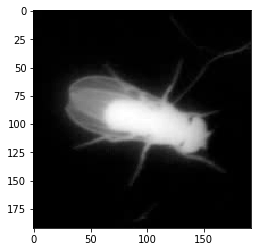

In [6]:
plt.imshow(frames[0,...,0], cmap='gray')
plt.show()

# Makes predictions for the full video

This loads batches of frames and makes predictions.

In [7]:
reader = VideoReader(HOME + '/deepposekit-data/datasets/fly/video.avi', batch_size=50, gray=True)
predictions = model.predict(reader, verbose=1)
reader.close()


675/675 [==============================] - 59s 87ms/step


True

# Save the data

Once you have your predictions you can save it however you wish. Here is an example using numpy.save

In [8]:
np.save(HOME + '/deepposekit-data/datasets/fly/predictions.npy', predictions)

This splits the predictions into their x-y coordinates, and confidence scores from each confidence map.

In [9]:
x, y, confidence = np.split(predictions, 3, -1)

Visualize the data output

/home/jake/.local/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


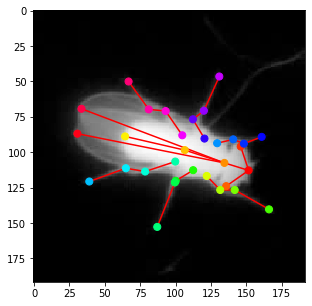

In [10]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/annotation_data_release.h5')

image = frames[0]
keypoints = predictions[0]

plt.figure(figsize=(5,5))
image = image if image.shape[-1] is 3 else image[..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[idx, 0], keypoints[jdx, 0]],
            [keypoints[idx, 1], keypoints[jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[:, 0], keypoints[:, 1],
            c=np.arange(data_generator.keypoints_shape[0]),
            s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Detect outlier frames

This is a basic example of how to use confidence scores and temporal derivatives to detect potential outliers and add them to the annotation set.

Plot the confidence scores

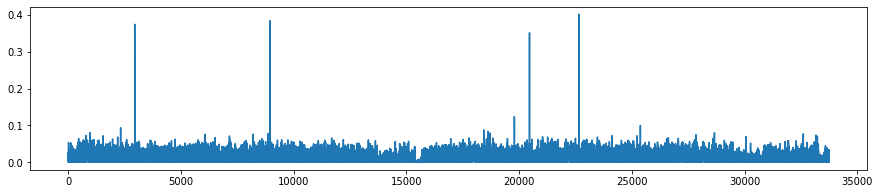

In [11]:
confidence_diff = np.abs(np.diff(confidence.mean(-1).mean(-1)))

plt.figure(figsize=(15, 3))
plt.plot(confidence_diff)
plt.show()

Use `scipy.signal.find_peaks` to detect outliers

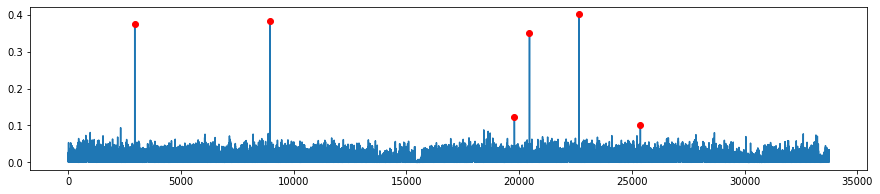

In [12]:
confidence_outlier_peaks = find_peaks(confidence_diff, height=0.1)[0]

plt.figure(figsize=(15, 3))
plt.plot(confidence_diff)
plt.plot(confidence_outlier_peaks, confidence_diff[confidence_outlier_peaks], 'ro')
plt.show()

Calculate the keypoint derivatives and plot them

In [13]:
time_diff = np.diff(predictions[..., :2], axis=0)
time_diff = np.abs(time_diff.reshape(time_diff.shape[0], -1))
time_diff = time_diff.mean(-1)
time_diff.shape

(33748,)

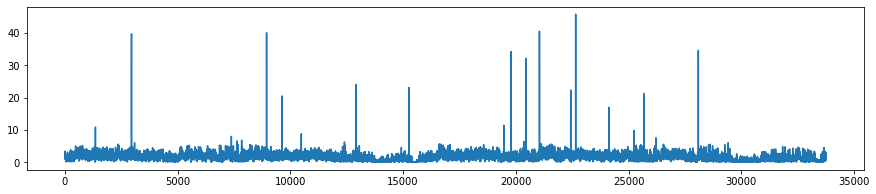

In [14]:
plt.figure(figsize=(15, 3))
plt.plot(time_diff)
plt.show()

Use `scipy.signal.find_peaks` to detect outliers

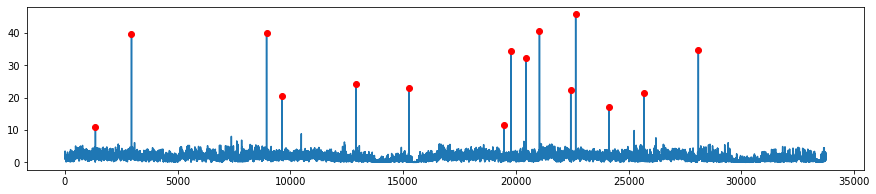

In [15]:
time_diff_outlier_peaks = find_peaks(time_diff, height=10)[0]

plt.figure(figsize=(15, 3))
plt.plot(time_diff)
plt.plot(time_diff_outlier_peaks, time_diff[time_diff_outlier_peaks], 'ro')
plt.show()

Combine the detected outliers into a single index

In [16]:
outlier_index = np.concatenate((confidence_outlier_peaks, time_diff_outlier_peaks))
outlier_index = np.unique(outlier_index) # make sure there are no repeats

Grab the frames and corresponding keypoints for the selected outliers

In [17]:
reader = VideoReader(HOME + '/deepposekit-data/datasets/fly/video.avi', batch_size=1, gray=True)

outlier_images = []
outlier_keypoints = []
for idx in outlier_index:
    outlier_images.append(reader[idx])
    outlier_keypoints.append(predictions[idx])

outlier_images = np.concatenate(outlier_images)
outlier_keypoints = np.stack(outlier_keypoints)

reader.close()

outlier_images.shape, outlier_keypoints.shape

((19, 192, 192, 1), (19, 32, 3))

Visualize the outlier frames and keypoint predictions

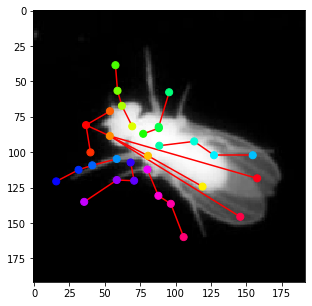

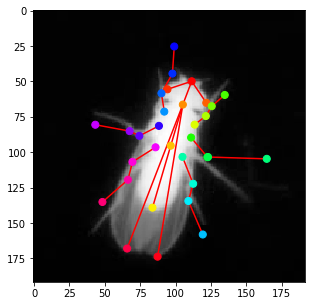

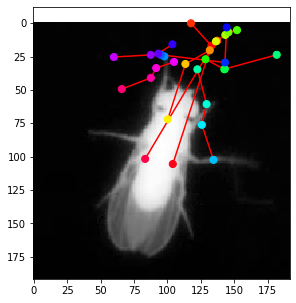

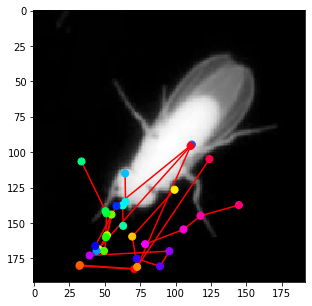

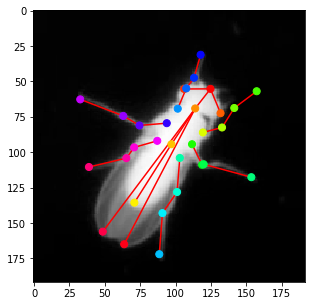

In [18]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/annotation_data_release.h5')

for idx in range(5):
    image = outlier_images[idx]
    keypoints = outlier_keypoints[idx]

    plt.figure(figsize=(5,5))
    image = image if image.shape[-1] is 3 else image[..., 0]
    cmap = None if image.shape[-1] is 3 else 'gray'
    plt.imshow(image, cmap=cmap, interpolation='none')
    for idx, jdx in enumerate(data_generator.graph):
        if jdx > -1:
            plt.plot(
                [keypoints[idx, 0], keypoints[jdx, 0]],
                [keypoints[idx, 1], keypoints[jdx, 1]],
                'r-'
            )
    plt.scatter(keypoints[:, 0], keypoints[:, 1],
                c=np.arange(data_generator.keypoints_shape[0]),
                s=50, cmap=plt.cm.hsv, zorder=3)

    plt.show()

# Merge outliers with the annotation set
Here we'll use a utility function `merge_new_images` to merge the outliers with our existing annotation set. You can then go annotate them with `deepposekit.annotate.Annotator`. Make sure to use the merged output file!

In [19]:
merge_new_images(
    datapath=HOME + '/deepposekit-data/datasets/fly/annotation_data_release.h5',
    merged_datapath=HOME + '/deepposekit-data/datasets/fly/annotation_data_release_merged.h5',
    images=outlier_images,
    keypoints=outlier_keypoints,
    # overwrite=True # This overwrites the merged dataset if it already exists
)

Load the data with `DataGenerator` and check that the merged data are there

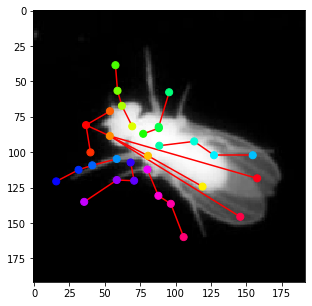

In [21]:
merged_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/annotation_data_release_merged.h5', mode="unannotated")

image, keypoints = merged_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Visualize the data as a video

This is an example of how to visualize the predicted posture data on the original video.

In [22]:
# TODO: Turn this into a function

data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/annotation_data_release.h5')
predictions = predictions[...,:2]
predictions *= 2

resized_shape = (data_generator.image_shape[0]*2, data_generator.image_shape[1]*2)
cmap = plt.cm.hsv(np.linspace(0, 1, data_generator.keypoints_shape[0]))[:, :3][:, ::-1] * 255

writer = VideoWriter(HOME + '/fly_posture.mp4', (192*2,192*2), 'MP4V', 30.0)
reader = VideoReader(HOME + '/deepposekit-data/datasets/fly/video.avi', batch_size=1)

for frame, keypoints in tqdm.tqdm(zip(reader, predictions)):
    frame = frame[0]
    frame = frame.copy()
    frame = cv2.resize(frame, resized_shape)
    for idx, node in enumerate(data_generator.graph):
        if node >= 0:
            pt1 = keypoints[idx]
            pt2 = keypoints[node]
            cv2.line(frame, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0,0,255), 2, cv2.LINE_AA)
    for idx, keypoint in enumerate(keypoints):
        keypoint = keypoint.astype(int)
        cv2.circle(frame, (keypoint[0], keypoint[1]), 5, tuple(cmap[idx]), -1, lineType=cv2.LINE_AA)
        
    writer.write(frame)

writer.close()
reader.close()

33749it [01:16, 443.11it/s]


True

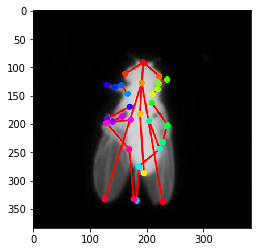

In [23]:
plt.imshow(frame[...,::-1])
plt.show()